## Descriptive Analytics

### Import Libraries

In [2]:
import pandas as pd
import numpy as np

import datetime as dt
import matplotlib.pyplot as plt

### Import Data

In [3]:
charging_sessions_data = pd.read_csv("charging_sessions.csv")
weather_data = pd.read_csv("weather_burbank_airport.csv")

### Operational Performance and Statistics on Charging Hubs
1. **Temporal Patterns and Seasonality**
* Demonstrate in a figure how the number of charging events varies during *the day, the week and between seasons*
- day **(Karoline)**
- week **(Marietta)**
- seasons (-)
* Note down observed patterns and possible explaination for them
2. **Key Performance Indicators (KPIs)**
* Define three time-dependent KPIs (to include in a dashboard for the hub operator):
    1. Peak and Off-Utilization Time (per Site) **(Marietta)**
    2. Idle Time per Hour per SiteID (disconnect - chargingdone) **(Angela)**
    3. Average Energy Deliverd per Session per SiteID per Hour **(CoCo)**
* Requirements for KPIs:
    * Must provide an immediate overview of the current hub operation
    * Show how the hub operation is doing in terms of *utilization or other business-related aspects*
* Provide explaination for each KPI selection in relation to the requirements and if necessary provide references
* Calculate *hourly values* for the KPIs and visualize them over time
* Note down observed trends and possible explainations for them
3. **Site Characteristics** ***(Simon)***
* Find out which of the two sites is supplying the private and public charging hub data
* Combine data from the tasks before to determine the difference in the operation of private and public charging hub data
* Note down explanation and reasoning behind the decision

### 1. Temporal Patterns and Seasonality

In [ ]:
# Demonstrate how the number of charging events varies during the day


In [ ]:
# Demonstrate how the number of charging events varies during the week


In [ ]:
# Demonstrate how the number of charging events varies between the seasons


Observed Trends are ...

### 2. Key Performance Indicators (KPIs)

We have choosen the following three time-dependent KPIs [...] because [...].

In [14]:

# Calculate hourly values of the KPI - Peak and Off-Utilization Time (per Site)
from datetime import datetime, timedelta 

# Create a DataFrame from the provided charging sessions data 
df = pd.DataFrame(charging_sessions_data)

# Convert 'connectionTime' and 'disconnectTime' columns from string to datetime objects.
# Note: This step is already done in Data_Preparation, so we can drop this if it is exported
df['connectionTime'] = pd.to_datetime(df['connectionTime'])
df['disconnectTime'] = pd.to_datetime(df['disconnectTime'])

# Initialize an array to store the occupied minutes and the count of occupied minutes for each hour of the day.
# The array will have 24 elements (one for each hour of the day, from 0 to 23).
# Each element is a list where:
# - index 0 will store the total number of occupied minutes in that hour.
# - index 1 will store the count of occupied minutes (i.e., how many times a minute was occupied)
minutes_array = [[0.0, 0.0] for _ in range(24)]  # Initialize each hour with [0.0, 0.0] (minutes, count)

# Iterate through the DataFrame
for row in df.itertuples():
        # Extract sessionID, connectionTime, and disconnectTime for each charging session
    sessionid = row.sessionID
    currenttime = row.connectionTime
    endtime = row.disconnectTime
    
    # Extract the hour and minute from the connectionTime and disconnectTime
    currenttimeStunde = currenttime.hour
    currenttimeMinute = currenttime.minute
    endtimeStunde = endtime.hour
    endtimeMinute = endtime.minute
    
    while currenttime < endtime:  # Keep going until we reach the disconnect time
        minutes_array[currenttimeStunde][0] += currenttimeMinute  # Add the minute to the corresponding hour in the minutes_array
        minutes_array[currenttimeStunde][1] += 1  # Increment the count for occupied minutes in this hour
       
        # Move to the next minute.
        if currenttime.minute == 59: # If it's the last minute of the hour
            if currenttime.hour == 23: # If it's also the last hour (23), we need to roll over to the next day.
                currenttime = currenttime + timedelta(minutes=1) # Add 1 minute to move to the next day, reset the hour to 0 -> for that we imported timedelta
            else:
                # Otherwise move to the next hour while resetting the minutes to 0
                currenttime = currenttime.replace(minute=0, hour=currenttime.hour + 1)
        else:
            # If the minute is not 59, only increase the minute by 1
            currenttime = currenttime.replace(minute=currenttime.minute + 1)
            
    # print(f"Session ID: {sessionid}")
    # print(f"  Connection Time - Stunde: {connectiontimeStunde}, Minute: {connectiontimeMinute}")

#print(minutes_array)

# Now: Calculation of the hourly utilization

# New array to store the hourly utilization (in percentage)
utilizationPerHour_array = []

# Iterate through all hours from 0 to 23 (the index corresponds to each hour of the day)
for index in range(24):  
    occupied_minutes = minutes_array[index][0]  # Total occupied minutes in this hour
    count = minutes_array[index][1]  # Number of occupied minutes (i.e., how many times minutes were occupied)
    
    # Calculate the utilization percentage, but only if count > 0 (so no division by 0)
    if count > 0:
        utilization = (occupied_minutes / (count * 60)) * 100  # utilization in percentage 
    else:
        utilization = 0  # If no minutes were occupied, utilization = 0%
    
    # Append the calculated utilization for this hour to the list
    utilizationPerHour_array.append(utilization)

# print
for index, utilization in enumerate(utilizationPerHour_array):
    print(f"hour {index}: {utilization:.2f}% Utilization")


hour 0: 45.01% Utilization
hour 1: 50.23% Utilization
hour 2: 48.85% Utilization
hour 3: 46.01% Utilization
hour 4: 47.77% Utilization
hour 5: 47.69% Utilization
hour 6: 37.97% Utilization
hour 7: 45.02% Utilization
hour 8: 45.43% Utilization
hour 9: 46.89% Utilization
hour 10: 60.39% Utilization
hour 11: 72.88% Utilization
hour 12: 67.40% Utilization
hour 13: 57.87% Utilization
hour 14: 47.67% Utilization
hour 15: 47.34% Utilization
hour 16: 45.86% Utilization
hour 17: 41.54% Utilization
hour 18: 46.63% Utilization
hour 19: 49.27% Utilization
hour 20: 48.08% Utilization
hour 21: 47.28% Utilization
hour 22: 48.80% Utilization
hour 23: 48.19% Utilization


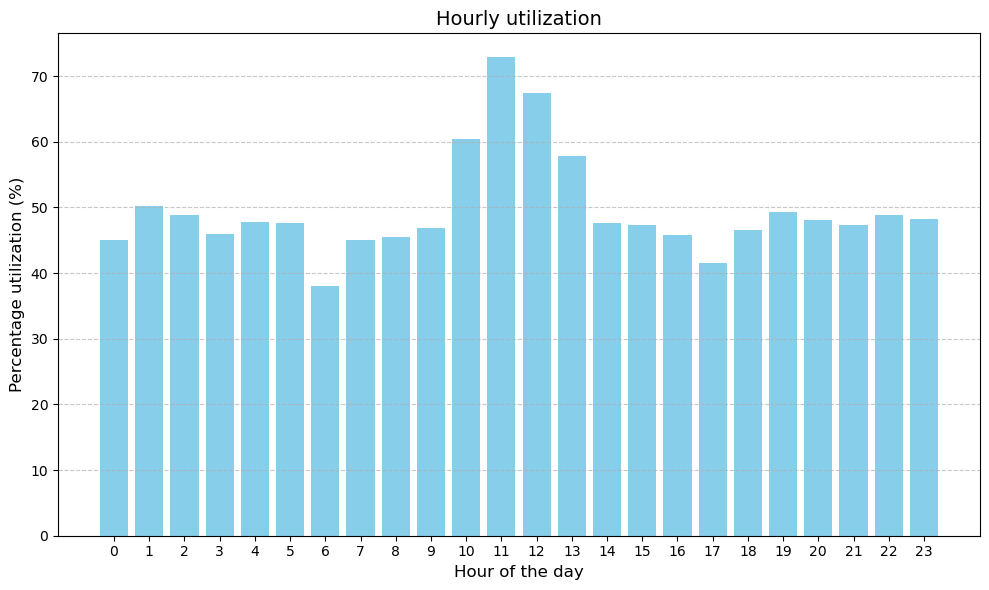

In [15]:
# Visualize hourly values of the KPIs over time

import matplotlib.pyplot as plt # import the necessary library for visualization

# Create a list representing the hours of the day (0 to 23) for the x-axis
hours = list(range(24))

# Create a bar chart 
plt.figure(figsize=(10, 6))  

# Plot the bar chart using the hours as the x-axis and 'utilizationPerHour_array' as the y-axis values, set color blue
plt.bar(hours, utilizationPerHour_array, color='skyblue')

# Axis labelling and titles
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Percentage utilization (%)', fontsize=12)
plt.title('Hourly utilization', fontsize=14)

plt.xticks(hours)  # Ensure that all hours (0 to 23) are shown on the X-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add a grid to the Y-axis to make the chart easier to read (dashed lines, light opacity)

plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements
plt.show() # Display the plot

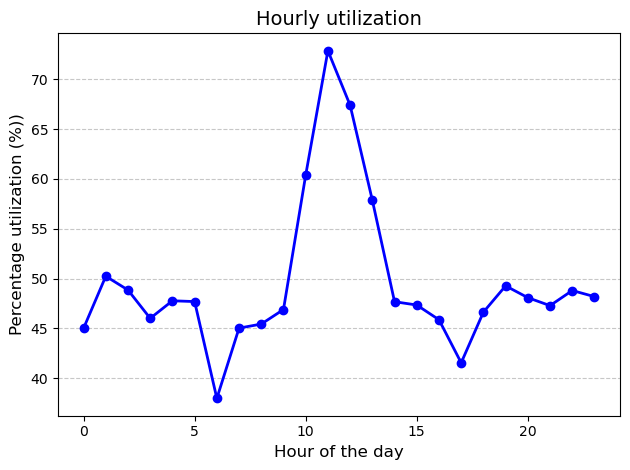

In [16]:
# Create a line chart
plt.plot(hours, utilizationPerHour_array, marker='o', color='b', linestyle='-', linewidth=2, markersize=6)

# Axis labelling and titles
plt.xlabel('Hour of the day', fontsize=12)
plt.ylabel('Percentage utilization (%))', fontsize=12)
plt.title('Hourly utilization', fontsize=14)

# Add a grid to the Y-axis to make the chart easier to read (dashed lines, light opacity)
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

plt.tight_layout() # Adjust the layout of the plot to prevent overlapping of labels or elements
plt.show() # Display the plot

### 3. Site Characteristics

In [ ]:
# Determine which of the two sites provided public or private data


The data with ... is public because ...